## Imports

In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
import operator
import os
import pickle
import csv
from datetime import datetime
from pathlib import Path
from collections import defaultdict, OrderedDict

import matplotlib.pyplot as plt
import numpy as np  
import h5py
import cv2
import pytz

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from keras import layers, regularizers, optimizers
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical, normalize
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback, EarlyStopping, LambdaCallback
from keras.initializers import glorot_normal, RandomNormal, Zeros
from keras.models import Model, load_model
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import GaussianNoise

from google.colab import drive
from google.colab import files

In [ ]:
def image_preprocessing(img, height=128, width=128):
    # enlarge image
    dimension = (height, width)
    img = cv2.resize(img, dimension, interpolation=cv2.INTER_LINEAR)
    # denoise
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = img[..., np.newaxis]
    return img

## Options

In [ ]:
#@markdown the model will be saved to '{out_dir}/{out_file}-{ddhhmm}.h5'\
#@markdown the history will be saved to '{out_dir}/{out_file}-{ddhhmm}.pickle'
out_dir = 'drive/MyDrive/a3' #@param {type:"string"}
out_file = 'talise3' #@param {type:"string"}
do_train = False #@param {type:"boolean"}
batch_size =  128#@param {type:"integer"}
epochs =   100#@param {type:"integer"}
#@markdown current training state will be save to '{out_dir}/{tmp_file}.h5' and '{out_dir}/{tmp_file}.pickle'\
#@markdown make sure to set it to something different for every session so you don't end up overwriting each other.
tmp_file = 'tmp' #@param {type:"string"}
#@markdown if true, try to restore last training state from {tmp_file}\
#@markdown While the optimizer's value should be restored as well, its impact on things such as ReduceLROnPlateau are unknown.
try_restore_tmp = False #@param {type:"boolean"}
#@markdown if true, try to load history from '{out_dir}/{load_file}.pickle'
do_load_history = True #@param {type:"boolean"}
load_file = 'talise3-141325' #@param {type:"string"}
#@markdown csv related stuffs are not implemented
do_generate_csv = False #@param {type:"boolean"}
csv_out_path = 'drive/MyDrive/sample.csv' #@param {type:"string"}
#@markdown if true, reduce the length of dataset to 30, useful to quick test on CPU
use_minimal = False #@param {type:"boolean"}

## Initialization

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
hf = h5py.File('drive/My Drive/MNIST_synthetic.h5', 'r')
# split data into training and validation set

test_x = hf["test_dataset"][:]

train_x, val_x, train_y, val_y = train_test_split(hf["train_dataset"][:], to_categorical(hf["train_labels"][:], 11), test_size=0.1, random_state=42, shuffle=True)

if use_minimal:
    train_x = train_x[:30]
    train_y = train_y[:30]
    val_x = val_x[:30]
    val_y = val_y[:30]

In [ ]:
print(f"Number of Images in Training Dataset: {train_x.shape[0]}")
print(f"Number of Images in Testing Dataset: {test_x.shape[0]}")

Number of Images in Training Dataset: 50400
Number of Images in Testing Dataset: 14000


In [ ]:
Path(out_dir).mkdir(parents=True, exist_ok=True)

out_filepath = f'{out_dir}/{out_file}-{datetime.now(pytz.timezone("Canada/Eastern")).strftime("%d%H%M")}'
tmp_filepath = f'{out_dir}/{tmp_file}'
load_filepath = f'{out_dir}/{load_file}'
out_filepath

'drive/MyDrive/a3/talise3-142329'

## Models

In [ ]:
def anothernet(input_dim=(128, 128, 1), out_dim=11):
    inputs = Input(shape=input_dim)

    x = BatchNormalization()(inputs)     
    x = GaussianNoise(0.1)(x)  
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)  
    x = Dropout(.2)(x)

    x = BatchNormalization()(x)  
    x = GaussianNoise(0.1)(x)  
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)      
    x = Dropout(.2)(x)

    x = BatchNormalization()(x)
    x = GaussianNoise(0.1)(x)  
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)    
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)  
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)   
    x = MaxPooling2D(pool_size=(2,2))(x) 
    x = Dropout(.25)(x) 

    x = BatchNormalization()(x)
    x = GaussianNoise(0.1)(x)  
    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)  
    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)    
    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)  
    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)  
    x = MaxPooling2D(pool_size=(2,2))(x)  
    x = Dropout(.25)(x) 
    x = GaussianNoise(0.05)(x)

    x = BatchNormalization()(x)
    x = Flatten()(x)   
    x = Dense(512,activation='relu')(x)
    x = Dropout(.5)(x)
    x = GaussianNoise(0.05)(x)
    outputs = [Dense(11, activation='softmax', name=f"digit_{i}")(x) for i in range(5)]
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    

In [ ]:
def orig_cnn():
    inputs = Input(shape=(128, 128, 1))

    x = BatchNormalization()(inputs)        
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)     

    x = Conv2D(32, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)    
    x = Dropout(.2)(x)

    x = Conv2D(64, (3,3), activation='relu')(x)  
    x = BatchNormalization()(x)  
    x = Conv2D(64, (3,3), activation='relu')(x)    
    x = Dropout(.2)(x)

    x = Conv2D(159, (3,3), activation='relu')(x)    
    
    x = Dropout(.2)(x) 

    x = Flatten()(x)    
    x = Dense(512,activation='relu')(x)    
    x = Dropout(.5)(x)    
    outputs = [Dense(11, activation='softmax', name=f"digit_{i}")(x) for i in range(5)]   

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
def simplenet(s = 2, weight_decay = 1e-2):
    inputs = Input(shape=(128, 128, 1))
    x = BatchNormalization()(inputs)

    # Block 1
    x = Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal())(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    
    # Block 2
    x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal())(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    
    # Block 3
    x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    
    # Block 4
    x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides = s)(x)
    x = Dropout(.2)(x)
    
    # Block 5
    x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    
    # Block 6
    x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal())(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    
    # Block 7
    x = Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal())(x)
    # Second Maxpooling
    x = MaxPooling2D(pool_size=(2,2), strides=s)(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
      
    # Block 8
    x = Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal())(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    
    # Block 9
    x = Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal())(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    # Third Maxpooling
    x = MaxPooling2D(pool_size=(2,2), strides=s)(x)
    
    
    # Block 10
    x = Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal())(x)
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)

    # Block 11  
    x = Conv2D(2048, (1,1), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal())(x)
    x = Dropout(.2)(x)
    
    # Block 12  
    x = Conv2D(256, (1,1), padding='same', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal())(x)
    # Fourth Maxpooling
    x = MaxPooling2D(pool_size=(2,2), strides=s)(x)
    x = Dropout(.2)(x)


    # Block 13
    x = Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005), kernel_initializer=glorot_normal())(x)
    # Fifth Maxpooling
    x = MaxPooling2D(pool_size=(2,2), strides=s)(x)

    # Final Classifier
    x = Flatten() (x)
    outputs = [Dense(11, activation='softmax', name=f"digit_{i}")(x) for i in range(5)]   
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

## Training

In [ ]:
train_x_processed = np.array([image_preprocessing(x) for x in train_x])
val_x_processed = np.array([image_preprocessing(x) for x in val_x])
def data_augmentor(data_generator):
    for x, y in data_generator:
        y = [y[:, i] for i in range(5)]
        yield x, y

In [ ]:
train_im_gen = ImageDataGenerator(rotation_range=10,zoom_range=0.1)
train_itr = train_im_gen.flow(train_x_processed, train_y, batch_size=batch_size)

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1, factor=.75)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# save/restore state callbacks
checkpoint_cb = ModelCheckpoint(
    filepath=tmp_filepath+'.h5', verbose=0,
    save_weights_only=False, save_freq='epoch',
)

saved_history = {}
def save_history(epoch, logs):
    saved_history['epoch'] = epoch
    if 'history' not in saved_history:
        saved_history['history'] = {}
        for key in logs:
            saved_history['history'][key] = []
    for key in logs:
        saved_history['history'][key].append(logs[key])

    with open(tmp_filepath + '.pickle', 'wb') as f:
        pickle.dump(saved_history, f)

savehistory_cb = LambdaCallback(on_epoch_end=lambda epoch, logs: save_history(epoch, logs))

# Training
if do_train:
    if try_restore_tmp:
        model = load_model(tmp_filepath+'.h5')
        print('Model loaded from tmp')
        with open(tmp_filepath + '.pickle', 'rb') as f:
            saved_history = pickle.load(f)
        initial_epoch = saved_history['epoch']
    else:
        model = talise_003()
        model.summary()
        initial_epoch = 0
    model.fit(
        data_augmentor(train_itr),
        initial_epoch=initial_epoch,
        validation_data=(val_x_processed, [val_y[:, i] for i in range(5)]),
        epochs=epochs, steps_per_epoch=len(train_itr) * 5,
        callbacks=[lr_reduction, early_stopping, checkpoint_cb, savehistory_cb], verbose=1
    )

    model.save_weights(out_filepath + '.h5', overwrite=True)
else:
    print('training skipped')

## Plots

Save & Load History

In [ ]:
if do_train:
    with open(out_filepath + '.pickle', 'wb') as f:
        pickle.dump(saved_history['history'], f)

if do_load_history:
    with open(load_filepath + '.pickle', 'rb') as f:
        history = pickle.load(f)
else:
    history = saved_history['history']

Helper functions

In [ ]:
def get_mean_by_id(h, id):
    k = lambda i, isVal: f'val_digit_{i}_{id}' if isVal else f'digit_{i}_{id}'
    data = [h[k(i,False)] for i in range(5)]
    val_data = [h[k(i,True)] for i in range(5)]
    return np.average(data, axis=0), np.average(val_data, axis=0), id

def get_single_by_id(h, id, idx):
    return h[f'digit_{idx}_{id}'], h[f'val_digit_{idx}_{id}'], id

def get_loss(h):
    return h[f'loss'], h[f'val_loss'], 'loss'

def show_plot(arr, title=None):
    plt.plot(arr[0])
    plt.plot(arr[1])
    plt.ylabel(arr[2])
    plt.xlabel('epoch')
    if title:
        plt.title(title)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Draw

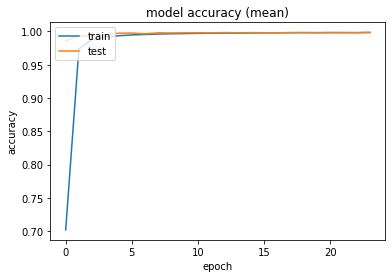

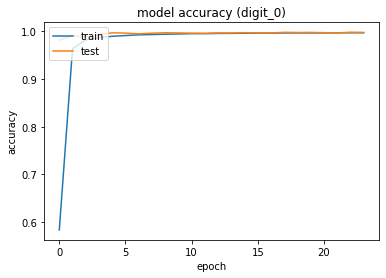

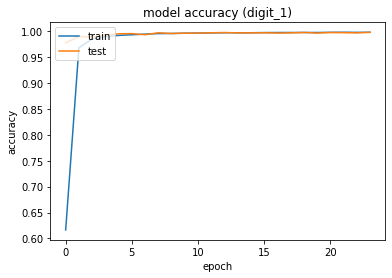

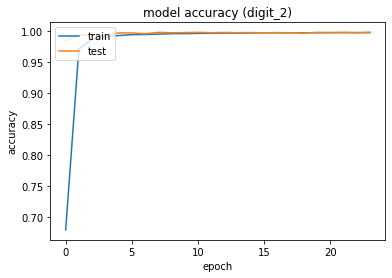

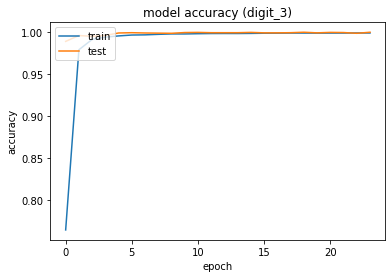

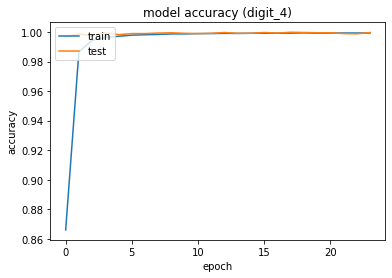

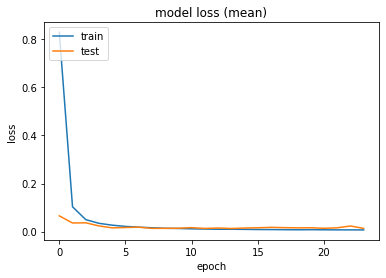

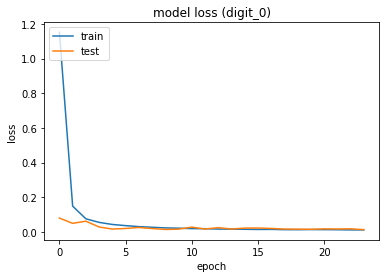

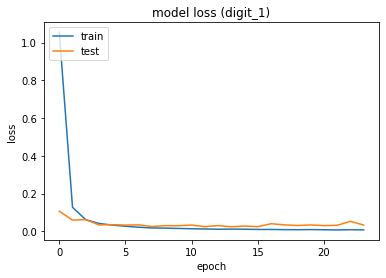

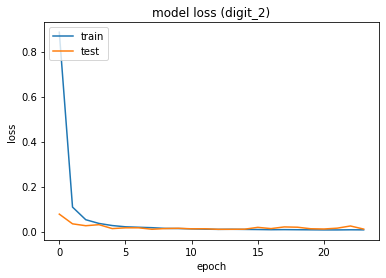

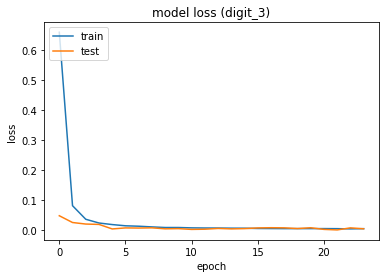

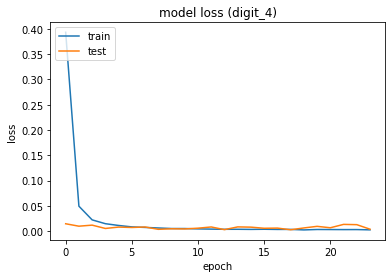

In [ ]:
show_plot(get_mean_by_id(history, 'accuracy'),'model accuracy (mean)')
show_plot(get_single_by_id(history, 'accuracy', 0),'model accuracy (digit_0)')
show_plot(get_single_by_id(history, 'accuracy', 1),'model accuracy (digit_1)')
show_plot(get_single_by_id(history, 'accuracy', 2),'model accuracy (digit_2)')
show_plot(get_single_by_id(history, 'accuracy', 3),'model accuracy (digit_3)')
show_plot(get_single_by_id(history, 'accuracy', 4),'model accuracy (digit_4)')

show_plot(get_loss(history))

show_plot(get_mean_by_id(history, 'loss'),'model loss (mean)')
show_plot(get_single_by_id(history, 'loss', 0),'model loss (digit_0)')
show_plot(get_single_by_id(history, 'loss', 1),'model loss (digit_1)')
show_plot(get_single_by_id(history, 'loss', 2),'model loss (digit_2)')
show_plot(get_single_by_id(history, 'loss', 3),'model loss (digit_3)')
show_plot(get_single_by_id(history, 'loss', 4),'model loss (digit_4)')

In [ ]:
def onehot_to_label(onehot):
    onehot = np.array(onehot)
    res = []
    for digits in onehot: 
        res.append(np.argmax(digits, axis=1))
    return np.column_stack(res)

def predict_with_ensemble(X, model_list):
    res = np.zeros((X.shape[0], 5))
    predictions = [onehot_to_label(model.predict(X)) for model in model_list]
    for i in range(X.shape[0]):
      all_preds = np.array([predictions[j][i] for j in range(len(model_list))])
      cand, cont = np.unique(all_preds, axis=0, return_counts=True)
      res[i] = cand[np.argmax(cont)]
    return res

def generate_output_csv_file(preds):
    preds = [[i, ''.join(str(int(x)) for x in pred)] for i, pred in enumerate(preds)]
    with open('sample.csv', 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['Id', 'Label'])
        writer.writerows(preds)
    files.download('sample.csv')

single output

In [ ]:
model = anothernet();
model.load_weights('drive/MyDrive/3/talise3-141656.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
test_x_processed = np.array([image_preprocessing(x) for x in test_x])
preds = model.predict(test_x_processed)
preds = onehot_to_label(preds)
generate_output_csv_file(preds)

NameError: ignored

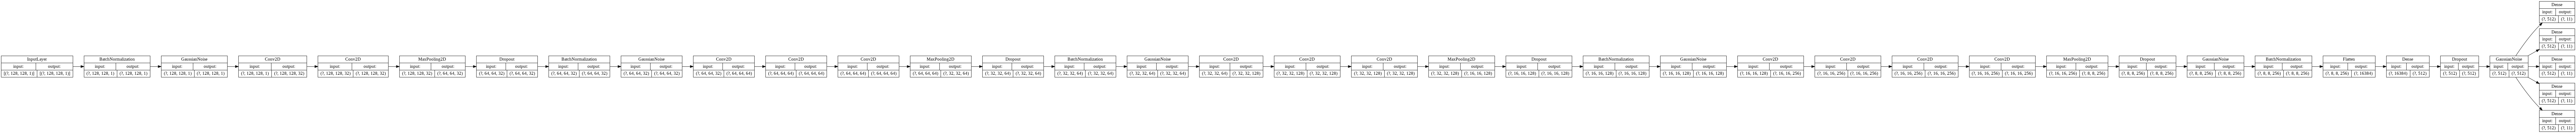

In [ ]:
model = anothernet();
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='LR', expand_nested=False, dpi=96)

ensemble output

In [ ]:
test_x_processed = np.array([image_preprocessing(x) for x in test_x])

model_01 = anothernet();
best_weights = "drive/My Drive/3/00.h5"
model_01.load_weights(best_weights)

model_02 = simplenet()
best_weights = "drive/My Drive/3/01.h5"
model_02.load_weights(best_weights)

model_03 = anothernet();
best_weights = "drive/My Drive/3/02.h5"
model_03.load_weights(best_weights)

model_04 = anothernet();
best_weights = "drive/My Drive/3/03.h5"
model_04.load_weights(best_weights)

model_05 = anothernet();
best_weights = "drive/My Drive/3/04.h5"
model_05.load_weights(best_weights)

model_06 = anothernet();
best_weights = "drive/My Drive/3/05.h5"
model_06.load_weights(best_weights)

model_07 = anothernet();
best_weights = "drive/My Drive/3/06.h5"
model_07.load_weights(best_weights)



In [ ]:
generate_output_csv_file(predict_with_ensemble(test_x_processed, [model_02, model_03, model_08]))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>